# Intro to Random Forests

In [81]:
import torch, cv2

In [82]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [84]:
PATH = "bulldozers/"

In [85]:
!ls {PATH}

'Data Dictionary.xlsx'	 random_forest_benchmark_test.csv   Train.csv
 Machine_Appendix.csv	 Test.csv			    Valid.csv
 median_benchmark.csv	 TrainAndValid.csv		    ValidSolution.csv


# Introduction to *Blue Book for Bulldozers*

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

In [86]:
!ls {PATH}

'Data Dictionary.xlsx'	 random_forest_benchmark_test.csv   Train.csv
 Machine_Appendix.csv	 Test.csv			    Valid.csv
 median_benchmark.csv	 TrainAndValid.csv		    ValidSolution.csv


In [87]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False)
df_valid = pd.read_csv(f'{PATH}Valid.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}Test.csv', low_memory=False)

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [88]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [89]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,11/2/2011 0:00,11/2/2011 0:00,11/2/2011 0:00,10/25/2011 0:00,10/25/2011 0:00


In [90]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2/16/2009 0:00,1932,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [91]:
df_raw.shape,df_valid.shape,df_test.shape

((401125, 53), (11573, 52), (12457, 52))

In [93]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Initial processing

In [94]:
m = RandomForestRegressor(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

/home/yashwant/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'Conventional'

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [95]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [96]:
add_datepart(df_valid, 'saledate')
df_valid.saleYear.head()

0    2012
1    2012
2    2012
3    2012
4    2012
Name: saleYear, dtype: int64

In [97]:
add_datepart(df_test, 'saledate')
df_test.saleYear.head()

0    2012
1    2012
2    2012
3    2012
4    2012
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [98]:
train_cats(df_raw)

In [99]:
train_cats(df_valid)
train_cats(df_test)

We can specify the order to use for categorical variables if we wish:

In [100]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [101]:
df_valid.UsageBand.cat.categories
df_test.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [102]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [103]:
df_valid.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_test.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [104]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [106]:
df_valid.UsageBand = df_valid.UsageBand.cat.codes
df_test.UsageBand = df_test.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [18]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [19]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [117]:
df_valid.to_feather('tmp/bulldozers-valid')
df_test.to_feather('tmp/bulldozers-test')

### Pre-processing

In the future we can simply read it from this fast format.

In [20]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [118]:
df_valid = pd.read_feather('tmp/bulldozers-valid')
df_test = pd.read_feather('tmp/bulldozers-test')

In [119]:
df_valid.shape,df_test.shape,df_raw.shape

((11573, 65), (12457, 65), (401125, 65))

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [21]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [120]:
df_valid,_, nas = proc_df(df_valid)
df_test,_, nas = proc_df(df_test)

In [130]:
df_valid.shape,df_test.shape,X_train.shape,df_raw.shape,df.shape

((11573, 65), (12457, 65), (389125, 66), (401125, 65), (401125, 66))

In [141]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11573 entries, 0 to 11572
Data columns (total 65 columns):
SalesID                        11573 non-null int64
MachineID                      11573 non-null int64
ModelID                        11573 non-null int64
datasource                     11573 non-null int64
auctioneerID                   11573 non-null int64
YearMade                       11573 non-null int64
MachineHoursCurrentMeter       11573 non-null float64
UsageBand                      11573 non-null int8
fiModelDesc                    11573 non-null int16
fiBaseModel                    11573 non-null int16
fiSecondaryDesc                11573 non-null int8
fiModelSeries                  11573 non-null int8
fiModelDescriptor              11573 non-null int8
ProductSize                    11573 non-null int8
fiProductClassDesc             11573 non-null int8
state                          11573 non-null int8
ProductGroup                   11573 non-null int8
ProductGroupD

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 66 columns):
SalesID                        401125 non-null int64
MachineID                      401125 non-null int64
ModelID                        401125 non-null int64
datasource                     401125 non-null int64
auctioneerID                   401125 non-null float64
YearMade                       401125 non-null int64
MachineHoursCurrentMeter       401125 non-null float64
UsageBand                      401125 non-null int8
fiModelDesc                    401125 non-null int16
fiBaseModel                    401125 non-null int16
fiSecondaryDesc                401125 non-null int16
fiModelSeries                  401125 non-null int8
fiModelDescriptor              401125 non-null int16
ProductSize                    401125 non-null int8
fiProductClassDesc             401125 non-null int8
state                          401125 non-null int8
ProductGroup                   401125 non-

In [140]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   401125 non-null int8
fiModelDesc                 401125 non-null category
fiBaseModel                 401125 non-null category
fiSecondaryDesc             263934 non-null category
fiModelSeries               56908 non-null category
fiModelDescriptor           71919 non-null category
ProductSize                 190350 non-null category
fiProductClassDesc          401125 non-null category
state                       401125 non-null category
ProductGroup

In [144]:
df_valid['auctioneerID_na']=df_valid.isnull()['auctioneerID']

In [152]:
df_test['auctioneerID_na']=df_test.isnull()['auctioneerID']

In [153]:
df_valid.shape,df_test.shape

((11573, 66), (12457, 66))

In [109]:
df_valid.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11573 entries, 0 to 11572
Data columns (total 65 columns):
SalesID                        11573 non-null int64
MachineID                      11573 non-null int64
ModelID                        11573 non-null int64
datasource                     11573 non-null int64
auctioneerID                   11573 non-null int64
YearMade                       11573 non-null int64
MachineHoursCurrentMeter       11573 non-null float64
UsageBand                      11573 non-null int8
fiModelDesc                    11573 non-null int16
fiBaseModel                    11573 non-null int16
fiSecondaryDesc                11573 non-null int8
fiModelSeries                  11573 non-null int8
fiModelDescriptor              11573 non-null int8
ProductSize                    11573 non-null int8
fiProductClassDesc             11573 non-null int8
state                          11573 non-null int8
ProductGroup                   11573 non-null int8
ProductGroupD

In [22]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [23]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   401125 non-null int8
fiModelDesc                 401125 non-null category
fiBaseModel                 401125 non-null category
fiSecondaryDesc             263934 non-null category
fiModelSeries               56908 non-null category
fiModelDescriptor           71919 non-null category
ProductSize                 190350 non-null category
fiProductClassDesc          401125 non-null category
state                       401125 non-null category
ProductGroup

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 66 columns):
SalesID                        401125 non-null int64
MachineID                      401125 non-null int64
ModelID                        401125 non-null int64
datasource                     401125 non-null int64
auctioneerID                   401125 non-null float64
YearMade                       401125 non-null int64
MachineHoursCurrentMeter       401125 non-null float64
UsageBand                      401125 non-null int8
fiModelDesc                    401125 non-null int16
fiBaseModel                    401125 non-null int16
fiSecondaryDesc                401125 non-null int16
fiModelSeries                  401125 non-null int8
fiModelDescriptor              401125 non-null int16
ProductSize                    401125 non-null int8
fiProductClassDesc             401125 non-null int8
state                          401125 non-null int8
ProductGroup                   401125 non-

We now have something we can pass to a random forest!

In [25]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/home/yashwant/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9830145632132565

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [122]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [129]:
df_raw.shape,raw_train.shape,df.shape

((401125, 65), (389125, 65), (401125, 66))

In [128]:
X_train.T.head(100)

,0,1,2,3,4,5,6,7,8,9,...,389115,389116,389117,389118,389119,389120,389121,389122,389123,389124
SalesID,1139246,1139248,1139249,1139251,1139253,1139255,1139256,1139261,1139272,1139275,...,4364541,4364545,4364546,4364547,4364559,4364560,4364561,4364563,4364737,4364741
MachineID,999089,117657,434808,1026470,1057373,1001274,772701,902002,1036251,1016474,...,1789509,1789509,1789509,1789509,1789509,1789509,1789509,1789509,2296205,2282910
ModelID,3157,77,7009,332,17311,4605,1937,3539,36003,3883,...,5264,28540,209,216,28657,11980,16467,216,665,665
datasource,121,121,121,121,121,121,121,121,121,121,...,172,172,172,172,172,172,172,172,172,172
auctioneerID,3,3,3,3,3,3,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1
YearMade,2004,1996,2001,2001,2007,2004,1993,2001,2008,1000,...,1998,2007,1999,2003,2001,1998,2003,2003,1999,1999
MachineHoursCurrentMeter,68,4640,2838,3486,722,508,11540,4883,302,20700,...,5865,4556,2926,4223,0,5388,7426,4223,2552,3210
UsageBand,2,2,0,0,1,2,0,0,2,1,...,2,2,2,2,-1,2,2,2,2,2
fiModelDesc,950,1725,331,3674,4208,493,1453,740,779,1771,...,2067,3703,2074,2091,4029,3682,3702,2091,3232,3232
fiBaseModel,296,527,110,1375,1529,175,419,243,250,540,...,686,1379,686,689,1425,1377,1379,689,1111,1111


# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [27]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [28]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/home/yashwant/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 24s, sys: 350 ms, total: 1min 24s
Wall time: 26.2 s
[0.0903715355292459, 0.24940780678235666, 0.9829313902400606, 0.8889117665335824]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up

In [29]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [30]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/home/yashwant/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3.08 s, sys: 268 µs, total: 3.08 s
Wall time: 955 ms
[0.11105710620400859, 0.3650101962758182, 0.9726282219318794, 0.7620651996549033]


## Single tree

In [31]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5220484030910896, 0.5800713442666302, 0.39517205688184087, 0.39908810990659527]


In [40]:
df_raw.fiProductClassDesc.cat.codes.

0         58
1         61
2         38
3          7
4         39
5          1
6         13
7          1
8         16
9         67
10         1
11        50
12        11
13         1
14         1
15         1
16        16
17        19
18        12
19         1
20        14
21        34
22        12
23        63
24         1
25        38
26        12
27        23
28        34
29        21
          ..
401095    16
401096    16
401097    16
401098    16
401099    16
401100    16
401101    16
401102    16
401103    16
401104    16
401105    16
401106    16
401107    16
401108    16
401109    16
401110    16
401111    16
401112    16
401113    16
401114    16
401115    16
401116    16
401117    16
401118    16
401119    12
401120    16
401121    16
401122    16
401123    12
401124    12
Length: 401125, dtype: int8

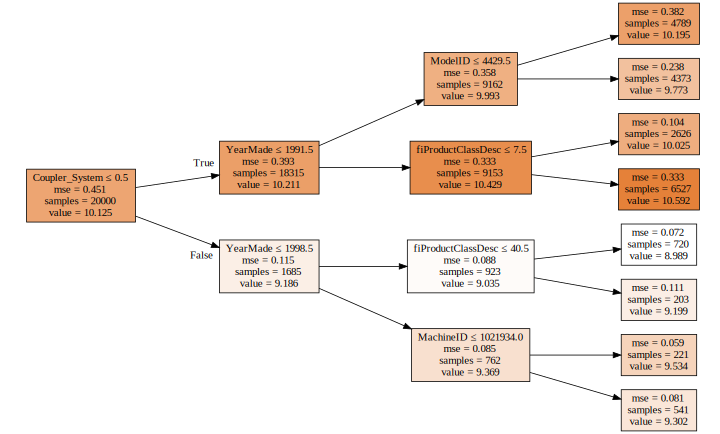

In [32]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [41]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[5.756054031998178e-17, 0.4809160964756273, 1.0, 0.5869652415982121]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

In [42]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/yashwant/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.10976263735644147, 0.3580089291032515, 0.9732625878011143, 0.7711053241289473]


We'll grab the predictions for each individual tree, and look at one example.

In [43]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.3501 ,  9.85219,  9.07681,  9.07681,  9.21034, 10.12663,  9.15905,  9.32812,  9.61581, 10.12663]),
 9.492249307618566,
 9.104979856318357)

In [44]:
preds.shape

(10, 12000)

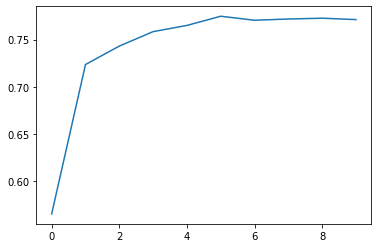

In [45]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [46]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10189986509161823, 0.3402285321757882, 0.9769560182705003, 0.7932766962621018]


In [47]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09615929119839328, 0.33325638860479695, 0.9794792697724097, 0.8016624513030057]


In [48]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09315865459141048, 0.332501019176591, 0.9807399806235055, 0.8025605485916525]


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [49]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09655745678715795, 0.33968707359280276, 0.9793089780703221, 0.7939341545823118, 0.8537371153083535]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [50]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [51]:
set_rf_samples(20000)

In [52]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/home/yashwant/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 8.74 s, sys: 422 ms, total: 9.16 s
Wall time: 4.38 s
[0.2405124628060709, 0.27521154750577176, 0.8791045386337971, 0.8647362950886353, 0.8665980666478517]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [53]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22723539009793237, 0.2641244436176354, 0.8920837696443467, 0.8754151698599406, 0.880538061278684]


### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [54]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [ ]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07828713008286803, 0.23818558990341943, 0.9871909898049919, 0.8986837887808402, 0.9085077721150765]


In [ ]:
t=m.estimators_[0].tree_

In [ ]:
dectree_max_depth(t)

45

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14073508031497292, 0.23337403295759937, 0.9586057939941005, 0.9027357960501001, 0.9068706269691232]


In [ ]:
t=m.estimators_[0].tree_

In [ ]:
dectree_max_depth(t)

35

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11502451037669295, 0.23371264152011234, 0.9723486962696959, 0.9024533448739421, 0.9083784022866831]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [111]:
m = RandomForestRegressor(n_estimators=60, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11821625787340916, 0.22756997324380884, 0.9707928459416904, 0.9075135966209742, 0.9137256291247927]


ValueError: Number of features of the model must match the input. Model n_features is 66 and input n_features is 65 

In [150]:
result_valid = m.predict(df_valid)

In [151]:
submission = pd.DataFrame()            
submission['SalesID']=df_valid['SalesID']
submission['SalePrice']=result
submission.head()

,SalesID,SalePrice
0,1222837,10.167468
1,1222839,11.133134
2,1222841,10.431238
3,1222843,10.204658
4,1222845,10.477531


In [156]:
result_test = m.predict(df_test)
submission_test = pd.DataFrame()            
submission_test['SalesID']=df_valid['SalesID']
submission_test['SalePrice']=result
submission_test.head()

,SalesID,SalePrice
0,1222837,10.167468
1,1222839,11.133134
2,1222841,10.431238
3,1222843,10.204658
4,1222845,10.477531


In [157]:
submission_test.to_csv('submission_test.csv',index=False)

In [158]:
!ls

 00-DO-NOT-USE-WITH-FASTAI-1.0.x.txt   lesson2-rf_interpretation.ipynb
 bulldozer_dl.ipynb		       lesson3-rf_foundations.ipynb
 bulldozer_linreg.ipynb		       lesson4-mnist_sgd.ipynb
 bulldozers			       lesson5-nlp.ipynb
'Ethics in Data Science.ipynb'	       ppt
 excel				       submission_test.csv
 fastai				       tmp
 images				       Untitled1.ipynb
 lession1_byme.ipynb		       Untitled.ipynb
 lesson1-rf.ipynb


In [63]:
m = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, max_features="sqrt", n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.15574584701818153, 0.25959829199075835, 0.9493046908246736, 0.8796484645369275, 0.9003637309622006]


In [64]:
m = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, max_features="log2", n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.17330514236202374, 0.27517547465845477, 0.9372291911463538, 0.8647717516473683, 0.8901222042053477]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)